In [2]:
# Predicting RB PPR/G

import pandas as pd 

# rb_stats from 2012 - 2022 (All Data from Pro Football Reference)
rb_stats = pd.read_csv('rb_base_stats.csv')

# Column renaming  

rb_stats.columns = ['Rk', 'Player', 'FantPt', 'Att', 'Tgt', 'Fmb', 'OffSnp', 'Season',
       'Age', 'Team', 'G', 'GS', 'FantPt.1', 'PPR', 'FantPt.2', 'PPR/G',
       'Fmb.1', 'FR', 'Yds', 'FRTD', 'FF', 'Rush Att', 'Rush Yds', 'Rush Y/A', 'Rush TD',
       'Rush Y/G', 'Rush 1D', 'Tgt.1', 'Rec', 'Rec Yds', 'Y/R', 'Rec TD', 'Rec Y/G', 'Ctch%',
       'Y/Tgt', 'Rec 1D', 'OffSnp.1', 'Off%', 'DefSnp', 'Def%', 'STSnp', 'ST %',
       'Pos', 'Draft', '-9999']

# Column narrowing 

rb_stats_need = rb_stats[['Player', 'Season',
       'Age', 'Team', 'G', 'GS', 'PPR', 'PPR/G',
       'Fmb', 'Rush Att', 'Rush Yds', 'Rush Y/A',
       'Rush TD', 'Rush Y/G', 'Rush 1D', 'Tgt', 'Rec', 'Rec Yds', 'Y/R',
       'Rec TD', 'Rec Y/G', 'Ctch%', 'Y/Tgt', 'Rec 1D', 'OffSnp', 'Off%', 'Pos', 'Draft', '-9999']]

In [4]:
# Variable Dictionary -> all stats unless labeled otherwise are for the corresponding NFL season

# Season -> NFL season
# G -> Games played
# GS -> Games Started
# PPR -> total fantasy points in a Season in a Points Per Reception (PPR) league
# PPR/G -> PPR per game
# Fmb -> total number of fumbles (including those recovered by own team)
# Rush Att -> Rushing attempts
# Rush Yds -> Rushing Yards
# Rush Y/A -> Rushing Yards per Attempt (Rush Yds/Rush Att)
# Rush TD -> Rushing Touchdowns
# Rush Y/G -> Rushing Yards per Game (Rush Yds/G)
# Rush 1D -> Rushing first downs
# Tgt -> Times targeted by a pass
# Rec -> Number of receptions
# Rec Yds -> Receiving Yards
# Y/R -> Yards per Reception (Rec Yds/Rec)
# Rec TD -> Number of receiving touchdowns
# Rec Y/G -> Number of receiving yards in a game (Rec Yds/G)
# Ctch% -> Number of passes caught over total number of targets (rec/tgt*100%)
# Y/Tgt -> Receiving yards per target (Rec Yds/Tgt)
# Rec 1D -> Receiving first downs
# OffSnp -> Number of offensive snaps played
# Off% -> Percentage of total offensive snaps for a team played
# Pos -> position played
# Draft -> Draft Round - Draft Pick Overall
# -9999 -> unique player-id
# Touches -> sum of targets and rush attempts

In [5]:
# Lets derive some new statistical categories

# I need a way to show how often a player is given an opportunity to score fantasy points.
# The main two opportunities a RB has to score fantasy points come from their receptions and their Rush Attempts
# I want this stat to be a measure of how involved a player is in their team's offense rather than purely a description of their
# skill. Therefore, I will use targets instead of receptions to describe the passing portion of their game. 

rb_stats_need['Touches'] = rb_stats_need['Tgt'] + rb_stats_need['Rush Att']

# Per game extension of Touches

rb_stats_need['Touches/G'] = rb_stats_need['Touches']/rb_stats_need['G']

In [6]:
# I also want a stat that describes the kind of running back a player is.
# For fantasy purposes, the three main types of running backs are passing backs, pure running backs, and hybrid backs

# Pure running backs: Derrick Henry, Jamaal Williams, Nick Chubb
# Passing backs: Austin Ekeler, Deandre Swift, Jerrick McKinnon 
# Hybrid backs: Saquon Barkley, Dalvin Cook, Devin Singletary 

# this can be captured by Rush Attempts per Target
rb_stats_need['Rush Att/Target'] = rb_stats_need['Rush Att']/rb_stats_need['Tgt']

# Rush Att/Target arbitrary classification (the thresholds are up for debate)
# Pure Running Backs: 6 and above
# passing backs : 3 and below
# Hybrid Backs between 3 and 6

In [7]:
# Another important factor is time in the NFL
# Age is a decent way of measuring this, but players enter into the NFL at different ages.
# Therefore, number of seasons in the NFL is a better way of measuring this.
# This is using the philosophy that wear and tear are the important factors rather than purely age. 
# Need to develop a way of deriving this.

# import historical data on running backs (2000-2022). 
all_av = pd.read_csv('all_av.csv')

# Data Cleaning

all_av_need = all_av[['Player', '-9999', 'Season', 'Team', 'Pos', 'Age', 'PPR', 'AV', 'G', 'Draft']]
all_av_need =all_av_need[all_av_need['Season'] != 'Season']
all_av_need[['Season', 'AV', 'G', 'Age']] = all_av_need[['Season', 'AV', 'G', 'Age']].astype(int)
all_av_need[['PPR']] = all_av_need[['PPR']].astype(float)

C:\Users\Sam\AppData\Local\Temp\ipykernel_13332\362606255.py:8: DtypeWarning: Columns (0,2,3,4,5,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  all_av = pd.read_csv('all_av.csv')


In [8]:
import numpy as np

# Method for determining Seasons in NFL

def seasons_in_nfl(x):
    sort = x.sort_values(by='Season')
    seasons_in_nfl = len(sort['Season'])
    seasons_list = np.arange(1, seasons_in_nfl + 1)
    sort['Seasons in NFL'] = seasons_list
    return(sort)

av_seasons = all_av_need.groupby(['Player', '-9999']).apply(seasons_in_nfl).reset_index(drop=True)

# This is an imperfect method for determinig seasons in the NFL because the data starts at the 2000 season but the NFL did not. 
# Therefore, all players labeled in the 2000 season are labeled as Season 1 rookies even though this might not be the case. 
# We can fix this by filtering out all players that were labeled in the 2000 Season.

In [9]:
rb_2000 = all_av_need.loc[(all_av_need['Season'] == 2000) & (all_av_need['Pos'] == 'RB'), '-9999']

# From this we can see that 2011 is the last season a player from 2000 played. 
# Our fantasy analysis is only looking at 2012-2022. Therefore we can just filter from 2012-2022 and can be sure the seasons
# in the NFL column is correct. 

all_av_need[all_av_need['-9999'].isin(rb_2000)].sort_values(by='Season', ascending=False)

# We will filter by this later. First, we should derive some more statistics

,Player,-9999,Season,Team,Pos,Age,PPR,AV,G,Draft
5433,Thomas Jones,JoneTh00,2011,KAN,RB,33,57.1,2,16,1-7
9368,Sammy Morris,MorrSa00,2011,DAL,RB,34,16.1,1,3,5-156
9776,Kevin Faulk,FaulKe00,2011,NWE,RB,35,16.1,1,7,2-46
4955,Ricky Williams,WillRi00,2011,BAL,RB,34,73.7,4,16,1-5
8531,Fred Taylor,TaylFr00,2010,NWE,RB,34,18.1,1,7,1-9
...,...,...,...,...,...,...,...,...,...,...
9933,Rabih Abdullah,AbduRa00,2000,TAM,RB,25,10.4,1,12,NaN
4217,Randy Jordan,JordRa00,2000,OAK,RB,30,102.2,6,16,NaN
10164,Maurice Smith,SmitMa00,2000,ATL,RB,24,8.4,0,10,NaN
10215,Michael Bates,BateMi00,2000,CAR,RB,31,12.1,1,16,6-150


In [10]:
# Calculate Career PPR/G 

summed_stats = av_seasons.groupby('-9999').sum().reset_index()
pprg_career = summed_stats['PPR']/summed_stats['G']
pprg_career_id_dict = dict(zip(summed_stats['-9999'], pprg_career))

av_seasons['Career PPR/G'] = [pprg_career_id_dict[ids] for ids in av_seasons['-9999']]

In [12]:
# Since this is about predicting future success we need a metric that measures how well a player did up until a certain season
# this can be achieved by looking at pre-season ppr/g 

pre_season_pprg_list = []

for i in range(len(av_seasons)):
    player_stats = av_seasons.iloc[[i]]
    season = int(player_stats['Season'])
    player_id = list(player_stats['-9999'])[0]
    slice_need = av_seasons[(av_seasons['-9999'] == player_id) & (av_seasons['Season'] < season)]
    if len(slice_need) > 0:
        ppr_sum = slice_need['PPR'].sum()
        g_sum = slice_need['G'].sum()
        if g_sum > 0:
            pre_season_pprg = ppr_sum/g_sum
            pre_season_pprg_list.append(pre_season_pprg)
        else:
            pre_season_pprg_list.append(np.nan)
    else:
        pre_season_pprg = np.nan
        pre_season_pprg_list.append(pre_season_pprg)
        
av_seasons['Pre-Season PPR/G'] = pre_season_pprg_list

In [13]:
# the positional names used in our stats document
rb_pos = set(rb_stats_need['Pos'])

# filter by relevant players
rbs_seasons = av_seasons[(av_seasons['Season'] >= 2012) & (av_seasons['Pos'].isin(rb_pos))]

In [14]:
# relevant data
merge_frame = rbs_seasons[['-9999', 'Season', 'Seasons in NFL', 'Career PPR/G', 'Pre-Season PPR/G']]

# merge the dataframes
rb_stats_seasons = rb_stats_need.merge(merge_frame, on=['-9999', 'Season'])

In [15]:
# loss of 2
len(rb_stats_need) - len(rb_stats_seasons)

2

In [16]:
# player id difference
set(rb_stats_need['-9999']).difference(set(rb_stats_seasons['-9999']))

{'PoolTa00'}

In [17]:
# irrelevant player can disregard loss
rb_stats_need[rb_stats_need['-9999'] == 'PoolTa00']

,Player,Season,Age,Team,G,GS,PPR,PPR/G,Fmb,Rush Att,...,Y/Tgt,Rec 1D,OffSnp,Off%,Pos,Draft,-9999,Touches,Touches/G,Rush Att/Target
1796,Tauren Poole,2014,25,CAR,1,0,NaN,NaN,1,1,...,NaN,NaN,2,0.2,RB,NaN,PoolTa00,1,1.0,inf


In [18]:
# Need to determine a method for measuring player relative performance over the course of a career.

rb_stats_seasons['Season to Career PPR/G Ratio'] = rb_stats_seasons['PPR/G']/rb_stats_seasons['Career PPR/G']
# This should demonstrate if this is an above (greater than 1) or below average (less than 1) season for a player.

In [19]:
# Want to show which seasons on average have the highest season to career PPR/G ratio but need to filter correctly.
# I only want to show players that have had a sufficiently long career to show how ppr/g changes with time.
# Going to filter by players with at least 7 seasons in NFL because this about the length of two contracts
# rookie contract being 4 years and second contract being around 3 years
# Also im only interested in fantasy relevent player (career ppr/g over 8)

player_8_seasons_list = rb_stats_seasons.loc[(rb_stats_seasons['Seasons in NFL'] == 7) & 
                                             (rb_stats_seasons['Career PPR/G'] >= 8), '-9999']
player_8_seasons = rb_stats_seasons[rb_stats_seasons['-9999'].isin(player_8_seasons_list)]

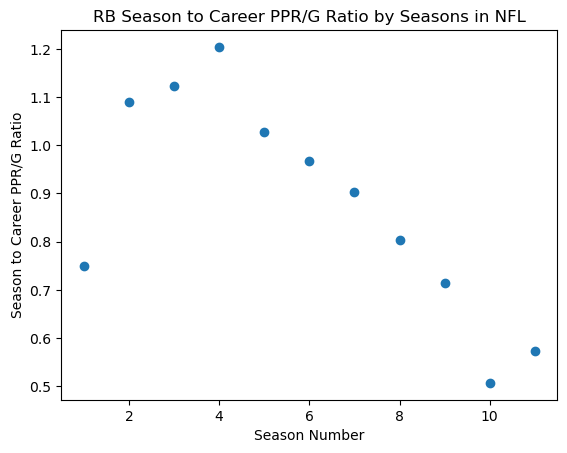

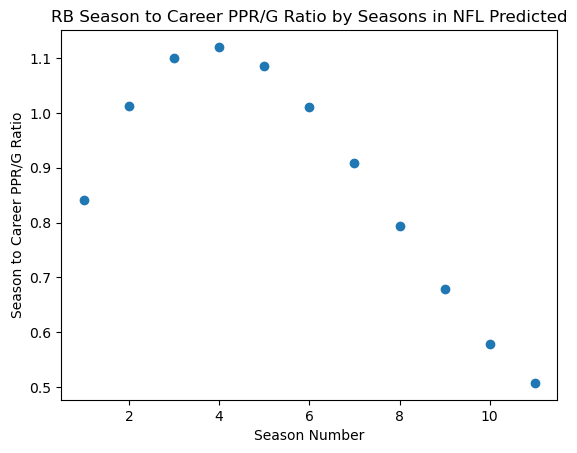

In [20]:
# Mean Season to Career PPR/G Ratio vs Season Number and line of best fit for RB
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

player_8_seasons['Season to Career PPR/G Ratio'] = player_8_seasons['Season to Career PPR/G Ratio'].fillna(0)

# find mean values for a particular season
season_ratio = []
values = np.arange(1, 12)
for i in values:
    season_ratio_mean = np.mean(player_8_seasons.loc[player_8_seasons['Seasons in NFL'] == i, 'Season to Career PPR/G Ratio'])
    season_ratio.append(season_ratio_mean)
    
plt.scatter(values, season_ratio)
plt.title('RB Season to Career PPR/G Ratio by Seasons in NFL')
plt.xlabel('Season Number')
plt.ylabel('Season to Career PPR/G Ratio')
plt.show()

# Create a model
# Non-linear relationship between variables should use polynomial features
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(np.array(player_8_seasons['Seasons in NFL']).reshape(-1,1), player_8_seasons['Season to Career PPR/G Ratio'])
prediction = model.predict(np.array(values).reshape(-1,1))

plt.scatter(values, prediction)
plt.title('RB Season to Career PPR/G Ratio by Seasons in NFL Predicted')
plt.xlabel('Season Number')
plt.ylabel('Season to Career PPR/G Ratio')
plt.show()

# The trend seems clear. Players enter the league and by season 2 they have close to their max fantasy value.
# This begins to taper off around years 5, 6, 7 and by season 8 the player is far below their career PPR/G 
# We can develop a rule of thumb that players should be targeted around seasons 2-7. 
# Another factor to consider is that if a player's career PPR/G is sufficiently high, it doesn't matter if they are on
# the decline. 0.8 of 22 is still higher than 1.2 of 12

In [21]:
# Players that meet this criteria from 2012-2022

set(player_8_seasons['Player'])

{'Adrian Peterson',
 'Ahmad Bradshaw',
 'Alfred Morris',
 'Arian Foster',
 'C.J. Anderson',
 'C.J. Spiller',
 'Carlos Hyde',
 'Chris Ivory',
 'Chris Johnson',
 'Chris Thompson',
 'Danny Woodhead',
 'Darren McFadden',
 'Darren Sproles',
 'David Johnson',
 'DeAngelo Williams',
 'DeMarco Murray',
 'Derrick Henry',
 'Devonta Freeman',
 'Doug Martin',
 'Duke Johnson',
 'Ezekiel Elliott',
 'Fred Jackson',
 'Giovani Bernard',
 'J.D. McKissic',
 'Jamaal Charles',
 'James White',
 'Jerick McKinnon',
 'Jonathan Stewart',
 'Jordan Howard',
 'Kenyan Drake',
 'Lamar Miller',
 'Latavius Murray',
 "Le'Veon Bell",
 'LeGarrette Blount',
 'LeSean McCoy',
 'Mark Ingram',
 'Marshawn Lynch',
 'Matt Forte',
 'Maurice Jones-Drew',
 'Melvin Gordon',
 'Peyton Hillis',
 'Pierre Thomas',
 'Rashad Jennings',
 'Reggie Bush',
 'Ryan Mathews',
 'Shane Vereen',
 'Tevin Coleman',
 'Theo Riddick'}

In [22]:
# need a column that transforms Draft into just Draft Pick Overall
# 259 will be a placeholder for an Undrafted player since 258 is the highest acutall draft pick

rb_stats_seasons['Draft'] = rb_stats_seasons['Draft'].fillna(0)
rb_stats_seasons['Draft Pick Overall'] = [259 if draft == 0 else int(str(draft)[2:len(str(draft))]) for draft in rb_stats_seasons['Draft']]

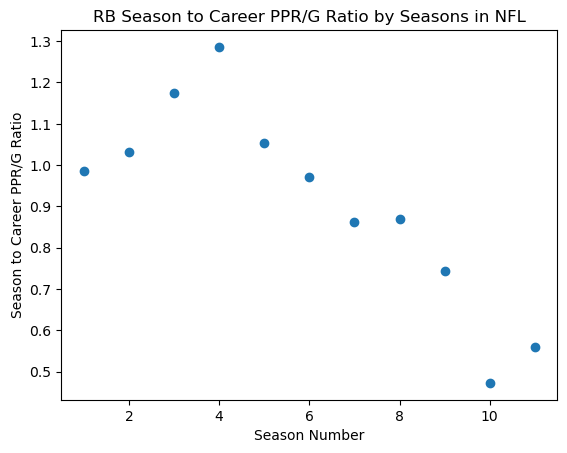

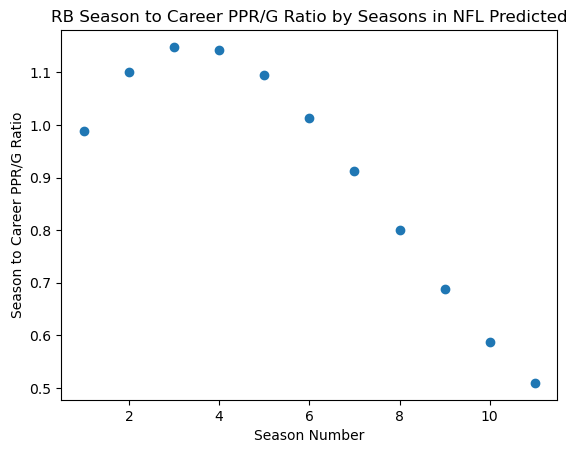

In [23]:
# Lets see how the trend changes with players drafted in the first two rounds 

player_8_seasons_list_draft = rb_stats_seasons.loc[(rb_stats_seasons['Seasons in NFL'] == 7) & 
                                                   (rb_stats_seasons['Career PPR/G'] >= 8) & 
                                                   (rb_stats_seasons['Draft Pick Overall'] <= 64), '-9999']

player_8_seasons_draft = rb_stats_seasons[rb_stats_seasons['-9999'].isin(player_8_seasons_list_draft)]

player_8_seasons_draft['Season to Career PPR/G Ratio'] = player_8_seasons_draft['Season to Career PPR/G Ratio'].fillna(0)

season_ratio = []
values = np.arange(1, 12)
for i in values:
    season_ratio_mean = np.mean(player_8_seasons_draft.loc[player_8_seasons_draft['Seasons in NFL'] == i, 'Season to Career PPR/G Ratio'])
    season_ratio.append(season_ratio_mean)
    
plt.scatter(values, season_ratio)
plt.title('RB Season to Career PPR/G Ratio by Seasons in NFL')
plt.xlabel('Season Number')
plt.ylabel('Season to Career PPR/G Ratio')
plt.show()

# Non-linear relationship between variables should use polynomial features
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(np.array(player_8_seasons_draft['Seasons in NFL']).reshape(-1,1), player_8_seasons_draft['Season to Career PPR/G Ratio'])
prediction = model.predict(np.array(values).reshape(-1,1))

plt.scatter(values, prediction)
plt.title('RB Season to Career PPR/G Ratio by Seasons in NFL Predicted')
plt.xlabel('Season Number')
plt.ylabel('Season to Career PPR/G Ratio')
plt.show()

# Similar, but the Sesaon 1 Ratio and Maximum value are higher

In [24]:
# Players that meet this criteria from 2012-2022

set(player_8_seasons_draft['Player'])

{'Adrian Peterson',
 'C.J. Spiller',
 'Carlos Hyde',
 'Chris Johnson',
 'Darren McFadden',
 'DeAngelo Williams',
 'Derrick Henry',
 'Doug Martin',
 'Ezekiel Elliott',
 'Giovani Bernard',
 'Jonathan Stewart',
 "Le'Veon Bell",
 'LeSean McCoy',
 'Mark Ingram',
 'Marshawn Lynch',
 'Matt Forte',
 'Maurice Jones-Drew',
 'Melvin Gordon',
 'Reggie Bush',
 'Ryan Mathews',
 'Shane Vereen'}

Text(0, 0.5, 'Season to Pre-Season PPR/G Ratio')

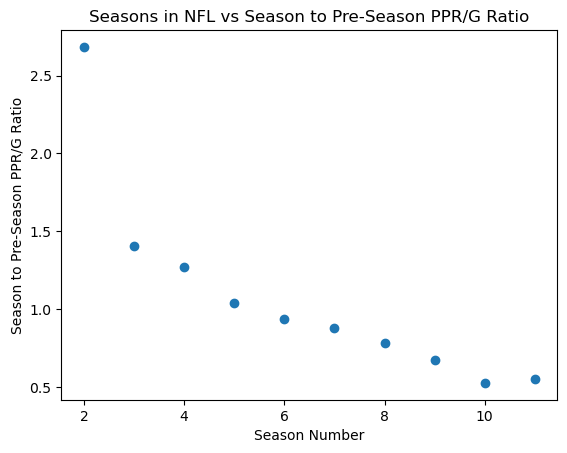

In [25]:
# When we are projecting player performance we will be looking at pre-season career ppr/g.
# Let's look at season to pre-season ppr/g ratio vs seasons in nfl and see how it differs.
# A Mean below 1 indicates that in that season number a player on average performs worse than his pre-season ppr/g 
rb_stats_seasons['Season to Pre-Season PPR/G Ratio'] = [j/k if k != 0 else np.nan for j, k in zip(rb_stats_seasons['PPR/G'], 
                                                                                        rb_stats_seasons['Pre-Season PPR/G'])]
mean_for_seasons_list = []

for i in range(2, 12):
    mean_for_seasons = np.mean(rb_stats_seasons.loc[(rb_stats_seasons['Seasons in NFL'] == i) & 
                                                    (rb_stats_seasons['-9999'].isin(player_8_seasons_list)), 
                                                    'Season to Pre-Season PPR/G Ratio'])
    mean_for_seasons_list.append(mean_for_seasons)
    
plt.scatter(range(2, 12), mean_for_seasons_list)
plt.title('Seasons in NFL vs Season to Pre-Season PPR/G Ratio')
plt.xlabel('Season Number')
plt.ylabel('Season to Pre-Season PPR/G Ratio')

# Sweet spot between 2 and 4 underperformance begins around seasons 5-7 and then season 8 drop off 

In [26]:
# Lets create some more statistics and see how they change over time

rb_stats_seasons['Total TD'] = rb_stats_seasons['Rush TD'] + rb_stats_seasons['Rec TD']

In [27]:
rb_stats_seasons['Total TD/G'] = rb_stats_seasons['Total TD']/rb_stats_seasons['G']

In [28]:
rb_stats_seasons['Total Yds'] = rb_stats_seasons['Rush Yds'] + rb_stats_seasons['Rec Yds']
rb_stats_seasons['Total Yds/G'] = rb_stats_seasons['Total Yds']/rb_stats_seasons['G']

In [29]:
rb_stats_seasons['Yds/Touch'] = rb_stats_seasons['Total Yds']/rb_stats_seasons['Touches']

Text(0, 0.5, 'Mean Yds/Touch')

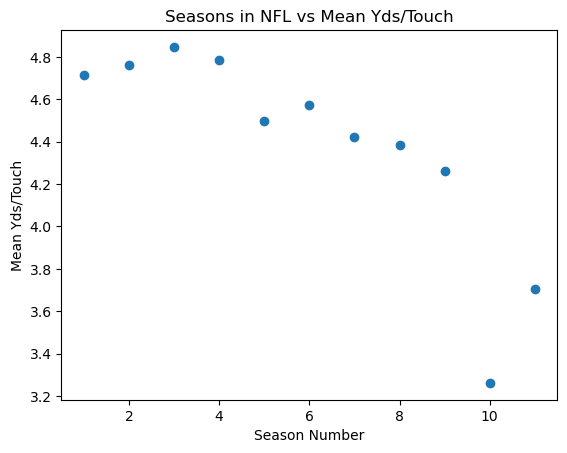

In [30]:
mean_for_seasons_list = []

for i in range(1, 12):
    mean_for_seasons = np.mean(rb_stats_seasons.loc[(rb_stats_seasons['Seasons in NFL'] == i) & 
                                                    (rb_stats_seasons['-9999'].isin(player_8_seasons_list)), 'Yds/Touch'])
    mean_for_seasons_list.append(mean_for_seasons)
    
plt.scatter(range(1, 12), mean_for_seasons_list)
plt.title('Seasons in NFL vs Mean Yds/Touch')
plt.xlabel('Season Number')
plt.ylabel('Mean Yds/Touch')

# The same general downard trend is shown here but without the initial rise (evidence that the initial jump in PPR/G is due to 
# underuse in the first year rather than gain in latent running ability)
# shows the same initial dip around season 5-6

Text(0, 0.5, 'Mean Y/A')

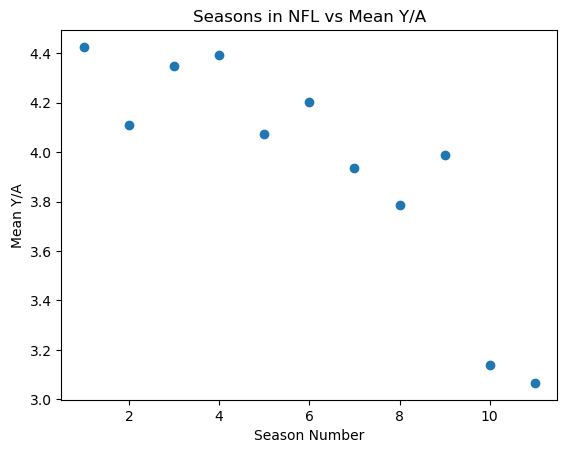

In [31]:
# Rush Yards per Attempt

mean_for_seasons_list = []

for i in range(1, 12):
    mean_for_seasons = np.mean(rb_stats_seasons.loc[(rb_stats_seasons['Seasons in NFL'] == i) & 
                                                    (rb_stats_seasons['-9999'].isin(player_8_seasons_list)), 'Rush Y/A'])
    mean_for_seasons_list.append(mean_for_seasons)
    
plt.scatter(range(1, 12), mean_for_seasons_list)
plt.title('Seasons in NFL vs Mean Y/A')
plt.xlabel('Season Number')
plt.ylabel('Mean Y/A')

Text(0, 0.5, 'Mean Y/R')

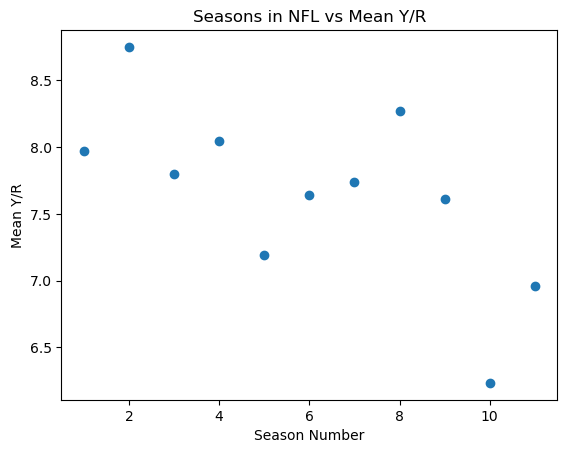

In [64]:
# Yards per reception

mean_for_seasons_list = []

for i in range(1, 12):
    mean_for_seasons = np.mean(rb_stats_seasons.loc[(rb_stats_seasons['Seasons in NFL'] == i) & 
                                                    (rb_stats_seasons['-9999'].isin(player_8_seasons_list)), 'Y/R'])
    mean_for_seasons_list.append(mean_for_seasons)
    
plt.scatter(range(1, 12), mean_for_seasons_list)
plt.title('Seasons in NFL vs Mean Y/R')
plt.xlabel('Season Number')
plt.ylabel('Mean Y/R')

# The Decline in yards per reception isn't as clear. This could be a sign that pass catching backs have more longevity.
# Season 5 decline and then season 6 return to average is interesting and could be a result of entering a new offense 
# since season 5 is typically a new contract

Text(0, 0.5, 'Mean Touches Per Game')

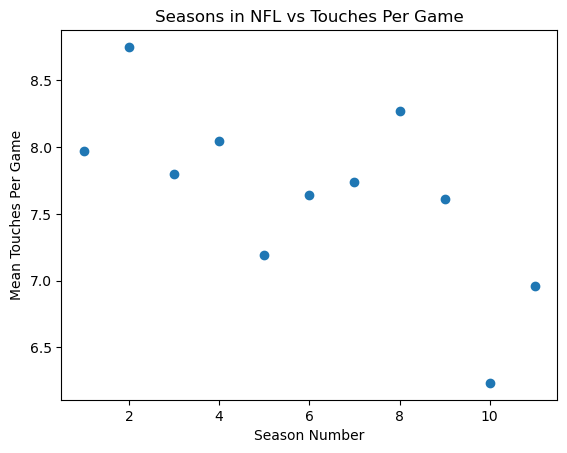

In [65]:
# Touches Per Game

mean_for_seasons_list = []

for i in range(1, 12):
    mean_for_seasons = np.mean(rb_stats_seasons.loc[(rb_stats_seasons['Seasons in NFL'] == i) & 
                                                    (rb_stats_seasons['-9999'].isin(player_8_seasons_list)), 'Y/R'])
    mean_for_seasons_list.append(mean_for_seasons)
    
plt.scatter(range(1, 12), mean_for_seasons_list)
plt.title('Seasons in NFL vs Touches Per Game')
plt.xlabel('Season Number')
plt.ylabel('Mean Touches Per Game')

# The trend is fairly sporadic with a clear drop off eventually

In [47]:
# What are the best predicters of ppr/g
# First, I need to filter by fantasy relevant players
# In most leagues, you would only play a running back if they scored at least 8 ppr/g over their career (there may
# be some special cases, but this will suffice)

rb_ppr8 = rb_stats_seasons[(rb_stats_seasons['Career PPR/G'] >= 8)]
rb_ppr8.corr()['PPR/G'].sort_values()

# Touches/G, Total TD/G, and Total Yds/G have the highest coorelation with PPR/G

Age                                -0.257546
Seasons in NFL                     -0.211095
Draft Pick Overall                 -0.195207
Rush Att/Target                    -0.129667
Season                              0.006296
Y/R                                 0.121545
Ctch%                               0.190531
Y/Tgt                               0.203690
Season to Pre-Season PPR/G Ratio    0.246507
Pre-Season PPR/G                    0.344487
G                                   0.370752
Rush Y/A                            0.382895
Yds/Touch                           0.398138
Fmb                                 0.422314
Rec TD                              0.489771
Career PPR/G                        0.583749
Rec 1D                              0.643029
GS                                  0.649987
Tgt                                 0.670094
Rec                                 0.677249
Rec Yds                             0.684618
Rec Y/G                             0.696841
Rush Att  

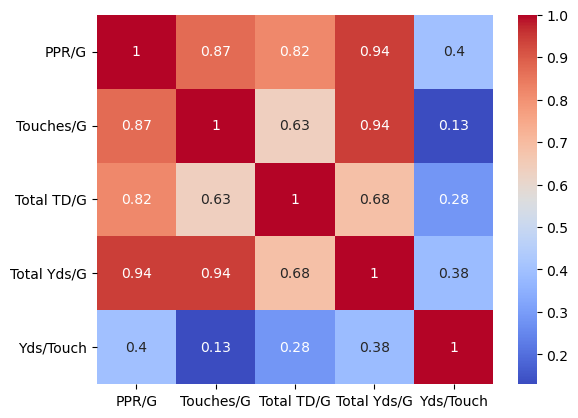

In [48]:
# Now lets look at how to predict these stats

import seaborn as sns

corr_matrix = rb_ppr8[['PPR/G', 'Touches/G', 'Total TD/G', 'Total Yds/G', 'Yds/Touch']].corr()

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

plt.show()

# Unsurprisingly Total Yds/G is highly coorelated with Touches/G
# TD/G seems to be equally predicted by Total Yds/G and Touches/G (since these are already highly coorelated)
# It seems as though Touches/G is the key to predicting TD/G, Total Yds/G and in turn PPR/G for running backs 

In [66]:
# Lets look at this past seasons top performers and see if this is the case

rb_stats_seasons[(rb_stats_seasons['Season'] == 2022) & (rb_stats_seasons['PPR/G'] >= 8) & 
                 (rb_stats_seasons['G'] > 1)][['Player', 'Team', 'G', 'Seasons in NFL', 
                'PPR/G', 'Touches/G', 'Total TD/G', 'Total Yds/G', 'Rush Y/A', 'Y/R', 'Yds/Touch', 
                'Rush Att/Target']].sort_values(by='PPR/G', ascending=False).reset_index(drop=True).head(50)

# This, for the most part, seems to be the case, but where it isn't it can be explained by a lack of TD production, or lack of 
# yards per touch

,Player,Team,G,Seasons in NFL,PPR/G,Touches/G,Total TD/G,Total Yds/G,Rush Y/A,Y/R,Yds/Touch,Rush Att/Target
0,Austin Ekeler,LAC,17,6,21.92,19.470588,1.058824,96.294118,4.5,6.7,4.945619,1.606299
1,Christian McCaffrey,CARSFO,17,6,20.96,20.705882,0.764706,110.588235,4.7,8.7,5.340909,2.259259
2,Josh Jacobs,LVR,17,4,19.31,23.764706,0.705882,120.764706,4.9,7.5,5.081683,5.312500
3,Derrick Henry,TEN,16,7,18.93,24.375000,0.812500,121.000000,4.4,12.1,4.964103,8.512195
4,Saquon Barkley,NYG,16,5,17.75,23.187500,0.625000,103.125000,4.4,5.9,4.447439,3.881579
5,Joe Mixon,CIN,14,6,17.11,20.357143,0.642857,89.642857,3.9,7.4,4.403509,2.800000
6,Nick Chubb,CLE,17,5,16.55,19.941176,0.764706,103.764706,5.0,8.9,5.203540,8.162162
7,Breece Hall,NYJ,7,1,16.44,15.857143,0.714286,97.285714,5.8,11.5,6.135135,2.580645
8,Tony Pollard,DAL,16,4,15.55,15.500000,0.750000,86.125000,5.2,9.5,5.556452,3.509091
9,James Conner,ARI,13,6,15.40,18.538462,0.615385,83.230769,4.3,6.5,4.489627,3.155172


In [54]:
# Get team abbreviation list

rb22_23 = rb_ppr8[rb_ppr8['Season'].isin(range(2021, 2023))]
teams = list(set([team for team in rb22_23['Team'] if len(team) == 3]))
teams.sort()

In [55]:
# lets import pff team run blocking scores for 2022 and see what has the highest coorelation with it. 
# Nota Bene: small sample size 

team_rblk_2022_dict = dict(zip(teams, [47.0, 83.7, 77.2, 50.7, 56.0, 73.1, 56.1, 69.2, 62.9, 59.4, 68.7, 55.9, 
                                       47.9, 62.0, 47.0, 72.5, 45.7, 57.3, 57.9, 69.9, 74.3, 53.0, 56.7, 61.1, 
                                       52.0, 76.5, 58.0, 57.8, 66.9, 53.9, 62.1, 55.6]))

In [56]:
rb22 = rb_ppr8[rb_ppr8['Season'] == 2022]

rb22['Team RBLK Score'] = [team_rblk_2022_dict[team] if len(team) == 3 else (team_rblk_2022_dict[team[0:3]] + team_rblk_2022_dict[team[3:6]])/2 for team in rb22['Team']]

In [57]:
# Aren't any super strong coorelations but some noticeable relationships
# Rush att/target goes up (more runs less passes to running back)
# Rush Y/A and Total TD/G go up
# Fumbles go down
# Enough to consider it an important factor in choosing a runningback. Especially in backs with a high rush att to target ratio

rb22.corr()['Team RBLK Score'].sort_values()

Fmb                                -0.242103
Rec                                -0.184849
Rec Y/G                            -0.171364
Tgt                                -0.166415
Rec Yds                            -0.126379
Rec 1D                             -0.125899
Ctch%                              -0.073964
Draft Pick Overall                 -0.057350
Age                                -0.024851
Seasons in NFL                     -0.022370
Career PPR/G                       -0.019159
Pre-Season PPR/G                   -0.000249
Career Availability Score           0.001196
GS                                  0.005673
Touches/G                           0.009623
Touches                             0.041449
OffSnp                              0.046084
Off%                                0.048280
PPR/G                               0.049919
PPR                                 0.053563
Y/Tgt                               0.054586
Total Yds/G                         0.064280
Y/R       

In [58]:
# Let's Create a statistic for measuring o-line independent rush effectiveness 
# AY/A = Y/A - (Team Run Block Score - Mean Team Run Block Score for a season) * coefficient
# The 0.0298 coefficient keeps the range similar to rush y/a, maintains a low coorelation with team rblk score, 
# and similar mean as rush y/a
# This should be computed on a per season basis (season relative)
# The method to find the coefficient is to minimize the r2 value between O-Line Adjusted Rush Y/A and Team RBLK Score
# This should be used to project rush y/a when a player changes team

team_scores = [47.0, 83.7, 77.2, 50.7, 56.0, 73.1, 56.1, 69.2, 62.9, 59.4, 68.7, 55.9, 47.9, 62.0, 47.0, 72.5, 45.7, 57.3, 57.9, 69.9, 74.3, 53.0, 56.7, 61.1, 52.0, 76.5, 58.0, 57.8, 66.9, 53.9, 62.1, 55.6]
rb22['O-Line Adjusted Rush Y/A'] = rb22['Rush Y/A'] - (rb22['Team RBLK Score'] - np.mean(team_scores))*0.0298

In [61]:
# Mean Run Blocking Score is around 60

rb22[rb22['Season'] == 2022][['Player', 'Team', 'Rush Y/A', 
                              'O-Line Adjusted Rush Y/A', 
                              'Team RBLK Score']].sort_values(by='O-Line Adjusted Rush Y/A', ascending=False)

,Player,Team,Rush Y/A,O-Line Adjusted Rush Y/A,Team RBLK Score
413,Breece Hall,NYJ,5.8,6.064475,52.00
788,Elijah Mitchell,SFO,6.2,6.020455,66.90
146,Travis Etienne,JAX,5.1,5.513475,47.00
98,Aaron Jones,GNB,5.3,5.448255,55.90
228,D'Andre Swift,DET,5.5,5.266815,68.70
905,Marlon Mack,DENSFO,5.3,5.232205,63.15
537,J.K. Dobbins,BAL,5.7,5.213515,77.20
67,Tony Pollard,DAL,5.2,5.139655,62.90
119,Rhamondre Stevenson,NWE,5.0,5.124415,56.70
17,Josh Jacobs,LVR,4.9,4.988655,57.90


In [49]:
# Player availability is another important factor

total_games = [16 if season < 2021 else 17 for season in rb_ppr8['Season']]
rb_ppr8['Total Games Available'] = total_games

In [50]:
rb_sum = rb_ppr8.groupby('-9999').sum()
g_sum = rb_sum['G']
total_g_sum = rb_sum['Total Games Available']
availability_score = g_sum/total_g_sum*100
availability_dict = dict(availability_score)
rb_ppr8['Career Availability Score'] = [availability_dict[player] for player in rb_ppr8['-9999']]

In [67]:
# Systematic analysis of running back fantasy strength
# Factors to consider include but are not necessarily limited to:

# Order based on my perceived importance (based on my previous analysis)
# 0. The baseline for your analysis should be taking a close look at a players career ppr/g and where it is trending
# 1. Touches per game: in most cases, a high number of touches translates to a large amount of points
# 2. Total TDS/G: in instances where a large amount of touches didn't translate to points it was almost always due to a low
#    number of touchdowns
# 3. Yds per Touch: Another reason could be a low yds per touch  
# 4. Rush Att to Target Ratio: In a ppr league, its alway better to have high touches and and a a low rush att to target ratio
#    since every reception is worth one point
# 5. Seasons in the NFL: the general trend is that running backs play worse the longer they are in the NFL. Consistent
#    throughout all the charts was a dip around the 5th and 8th season. Perhaps cooresponding to a change in team and as a 
#    result, a player's role on that team.
# 6. Availability Score: the less a player plays the less they can score for your team. 
# 7. Changes in Roster: As mentioned in the Seasons in NFL portion, a change in roster could signify a change in role. This could
#    mean less touches, and, furthermore it generally takes time for a player to get used to a new environment. In addition, 
#    a runningback to a certain degree is dependent on their offensive line. Consider evaluating a players O-Line Adjusted Rush
#    yards per attempt when analyzing a player that has recently switched teams or up/downgraded their O-Line.

In [82]:
# Sample Analysis: Joe Mixon 2023 Season Prediction

mixon = rb_ppr8[rb_ppr8['Player'] == 'Joe Mixon'][['Player', 'Team', 'Season','Seasons in NFL', 'PPR/G', 'Pre-Season PPR/G', 
                                           'Career PPR/G', 'Season to Pre-Season PPR/G Ratio', 'Touches/G', 'Total TD/G', 
                                           'Yds/Touch', 'Rush Att/Target', 
                                           'Career Availability Score']].sort_values(by='Seasons in NFL')
mixon

,Player,Team,Season,Seasons in NFL,PPR/G,Pre-Season PPR/G,Career PPR/G,Season to Pre-Season PPR/G Ratio,Touches/G,Total TD/G,Yds/Touch,Rush Att/Target,Career Availability Score
348,Joe Mixon,CIN,2017,1,10.09,NaN,15.46375,NaN,15.142857,0.285714,4.306604,5.235294,81.632653
81,Joe Mixon,CIN,2018,2,17.39,10.092857,15.46375,1.723001,20.857143,0.642857,5.013699,4.309091,81.632653
97,Joe Mixon,CIN,2019,3,14.09,13.739286,15.46375,1.025526,20.187500,0.500000,4.408669,6.177778,81.632653
518,Joe Mixon,CIN,2020,4,16.60,13.865909,15.46375,1.197181,24.166667,0.666667,3.903448,4.576923,81.632653
34,Joe Mixon,CIN,2021,5,17.99,14.194000,15.46375,1.267437,21.250000,1.000000,4.467647,6.083333,81.632653
121,Joe Mixon,CIN,2022,6,17.11,15.115152,15.46375,1.131977,20.357143,0.642857,4.403509,2.800000,81.632653


In [96]:
# Gets the ball more than the average fantasy back 1.05 standard deviations above the mean
# Nota Bene: players analyzed are those that have a career ppr/g over 8
(np.mean(mixon['Touches/G']) - np.mean(rb_ppr8['Touches/G']))/np.std(rb_ppr8['Touches/G'])

1.04852257769284

In [98]:
# Average Touches/G among eligible 
np.mean(rb_ppr8['Touches/G'])

13.907204051768641

(array([ 23.,  47.,  66.,  96., 106.,  95.,  99.,  50.,  25.,   5.]),
 array([ 0.    ,  2.9875,  5.975 ,  8.9625, 11.95  , 14.9375, 17.925 ,
        20.9125, 23.9   , 26.8875, 29.875 ]),
 <BarContainer object of 10 artists>)

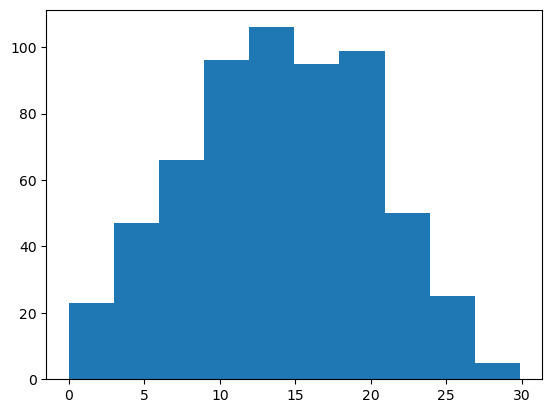

In [97]:
# Histogram of Touches/G
plt.hist(rb_ppr8['Touches/G'])

In [93]:
# Tends to Score more TD's than the average back 0.65 standard deviations above the mean
(np.mean(mixon['Total TD/G']) - np.mean(rb_ppr8['Total TD/G']))/np.std(rb_ppr8['Total TD/G'])

0.6512050656276156

In [99]:
# Average Total TD/G among eligible 
np.mean(rb_ppr8['Total TD/G'])

0.42195892609675795

(array([157., 148., 157.,  85.,  31.,  23.,   8.,   1.,   0.,   2.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

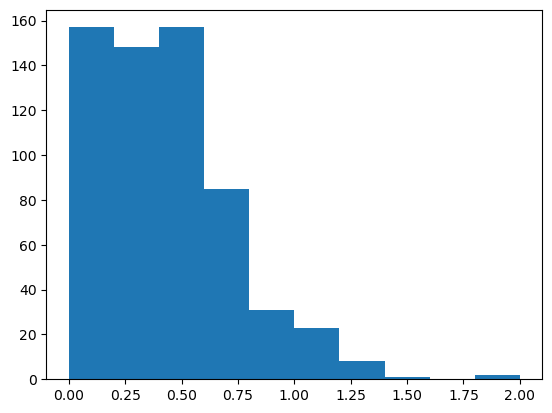

In [94]:
# Histogram of Total TD/G
plt.hist(rb_ppr8['Total TD/G'])

In [101]:
# Mixon has a below average yds/touch -0.13 standard deviations below the mean
(np.mean(mixon['Yds/Touch']) - np.mean(rb_ppr8['Yds/Touch']))/np.std(rb_ppr8['Yds/Touch'])

-0.13996651083086176

In [102]:
# On average, Mixon is more available than the average back 0.42 standard deviations above the mean
(np.mean(mixon['Career Availability Score']) - np.mean(rb_ppr8['Career Availability Score']))/np.std(rb_ppr8['Career Availability Score'])

0.41835441413361735

(array([  2.,   0.,   5.,   2.,   7.,  76., 113., 176., 137.,  94.]),
 array([  5.88235294,  15.29411765,  24.70588235,  34.11764706,
         43.52941176,  52.94117647,  62.35294118,  71.76470588,
         81.17647059,  90.58823529, 100.        ]),
 <BarContainer object of 10 artists>)

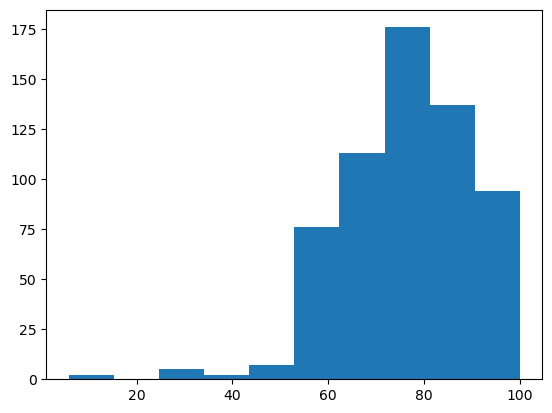

In [103]:
plt.hist(rb_ppr8['Career Availability Score'])

In [117]:
# One thing to consider is that Joe Mixon has had a below average O-Line for most of his career. This is reflected in his O-line
# Adjusted Rush Y/A
# This may get better with the addition of Orlando Brown Jr. 

rb22[rb22['Player'] == 'Joe Mixon'][['Player', 'Rush Y/A', 'O-Line Adjusted Rush Y/A']]

,Rush Y/A,O-Line Adjusted Rush Y/A
121,3.9,4.042295


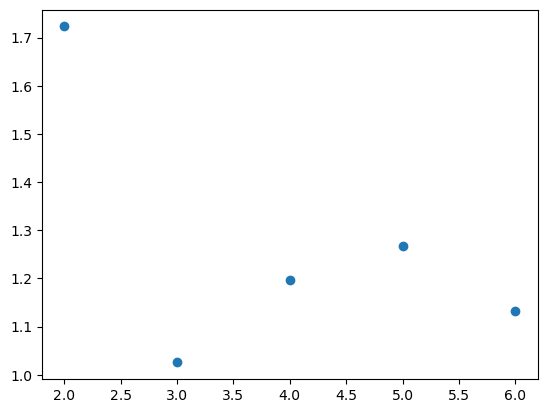

In [104]:
# Mixon throughout his career has performed above expecatation every season (if expectation is 1.0 i.e. season ppr/g 
# directly cooresponds with pre-season ppr/g)
# a dip occured last year but he is still above 1.1. I would expect the dip to continue and his range of values to lie between 1.1
# and 0.9 for 2023
# Players on average aren't above 1.0 in their 7th season. The dip below happens around season 6 for most and it seems as though
# mixon is heading in that direction
plt.scatter(mixon['Seasons in NFL'], mixon['Season to Pre-Season PPR/G Ratio'])

In [115]:
# Rough estimation of mixon's ppr/g for 2023
lower_bound = np.mean(mixon['Career PPR/G'])*0.9
upper_bound = np.mean(mixon['Career PPR/G'])*1.1

print(f'Lower Bound: {lower_bound} Upper Bound: {upper_bound}')

Lower Bound: 13.917375 Upper Bound: 17.010125000000002


In [118]:
# In summary, Mixon is a player that gets a large volume of touches and scores an above average amount of times. In recent years
# with the introduction of Joe Burrow, Mixon has been used much more often in the passing game. Therefore, he has a pass catching
# upside in ppr leagues. Mixon isn't getting any younger and is likely to regress this coming season. 
# Throughout his career, he has had a below average yards per touch and this likely to continue, but he makes up for with his
# scoring and touches
# Mixon has been a sturdy back and has been available most of his career.
# Although he is regressing, he still plays an important part in Cincinnati's offense. I would pay close attention to Bengals
# news as he is potentially a salary cap casualty. Furthermore, Cincinnati may draft a runningback and reduce Mixon's role in 
# in the offseason.